# House Prices - Regression Predictions YData 2024    

**Team: Random Forest Rangers** ([Dmitry Gufranov](https://www.linkedin.com/in/gufranov/), [Evgenia Amineva](https://www.linkedin.com/in/janeami/), [Valeriya Vazhnova](https://www.linkedin.com/in/gufranov/))

### Import libraries

In [67]:
import pandas as pd 
import numpy as np 
import datetime

# vizualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# ml
from lightgbm import LGBMRegressor
import catboost as cb
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR


from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit

In [2]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

### Loading the data

In [4]:
# load the train data
df = pd.read_csv('train.csv')
display(df.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Preprocessing

In [6]:
# these lists were created in Feat_eng_expl file

cat_cols_oe = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']

cat_cols_oh = ['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', \
               'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', \
                'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence', 'SaleType', \
                'SaleCondition', 'MSSubClass', 'OverallCond', 'KitchenAbvGr', 'MoSold', 'YrSold']

cat_cols_tdrop = ['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'PoolQC', 'MiscFeature', 'MiscVal']

num_cols_norm = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', \
                 '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']

num_cols_asis = ['OverallQual', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']

num_cols_tdrop = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']

num_cols_flag = ['BsmtFinSF2', 'LowQualFinSF', '3SsnPorch', 'PoolArea']

In [15]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin


def fill_miss(df):

    df_upd = df.copy()

    # fill columns wheare missing values have a meaning NA
    feat_wn = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtExposure',
       'BsmtFinType1', 'BsmtCond', 'BsmtQual']
    
    for c in df_upd.columns:
        if c in feat_wn:
            df_upd[c].fillna('NA', inplace=True)

    # fill with mean missing num features
    num_si = SimpleImputer(strategy='mean')
    num_col= df_upd.dtypes[df_upd.dtypes != 'object']
    df_upd[num_col.index] = num_si.fit_transform(df_upd[num_col.index])

    # fill with most frequent categorical features
    cat_si = SimpleImputer(strategy='most_frequent')
    cat_col= df_upd.dtypes[df_upd.dtypes == 'object']
    df_upd[cat_col.index] = cat_si.fit_transform(df_upd[cat_col.index])


    return df_upd

def feat_eng(df, num_cols_tdrop, num_cols_norm, num_cols_flag):
    df_upd = df.copy()


    # create new feature for bathrooms
    # corr coef
    #     0.22512486719612368
    # -0.012188876310787316
    # 0.6359570562496957
    # 0.34300754918568294

    df_upd['Bath'] = 0.225 * df['BsmtFullBath'] + (-0.0121) * df['BsmtHalfBath'] + 0.636 * df['FullBath'] + 0.343 * df['HalfBath']

    # drop columns
    df_upd = df_upd.drop(num_cols_tdrop, axis=1)

    # # normalizing
    # power = PowerTransformer(method='yeo-johnson', standardize=True)
    # df_upd[num_cols_norm] = power.fit_transform(df_upd[num_cols_norm])

    for c in num_cols_flag:
        if c in df_upd.columns:
            df_upd[c] = df_upd[c].apply(lambda x: 1 if x>0 else 0)


    return df_upd

def transf_cat(df, cat_cols_oh, cat_cols_oe, cat_cols_tdrop):
    df_upd = df.copy()

    # merge values in LotConfig
    if 'LotConfig' in  df_upd.columns:
        df_upd.loc[df_upd['LotConfig']=='FR3', 'LotConfig'] = 'FR2'


    #
    if 'LandSlope' in  df_upd.columns:
        df_upd.loc[df_upd['LandSlope']=='Sev', 'LandSlope'] = 'Mod'
        df_upd['GtlSlope'] = df_upd['LandSlope'].apply(lambda x: 1 if x=='Gtl' else 0)
        df_upd[['LandSlope', 'GtlSlope']][:5]

    # merge values in Conditional1
    for cc in [['RRNn', 'RRAn'], ['RRNe', 'RRAe'], ['PosN', 'PosA']]:
        df_upd.loc[df_upd['Condition1']==cc[0], 'Condition1'] = cc[1]


    # transform 
    oec = OrdinalEncoder(categories = [['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']]) 
    # for cc in ['FireplaceQu', 'KitchenQual', 'HeatingQC', 'PoolQC', 'BsmtQual', 'ExterQual', 'ExterCond']:
    for cc in cat_cols_oe:
        if cc in df_upd.columns:
            df_upd[cc] = oec.fit_transform(df_upd[[cc]])

    
    class GetDummiesTransformer(BaseEstimator, TransformerMixin):
        def __init__(self, *args, pandas_params={}, **kwargs):
            super().__init__(*args, **kwargs)
            self._pandas_params = pandas_params
        def fit(self, X, y=None):
            return self
        def transform(self, X, y=None):
            return pd.get_dummies(X, dtype = 'int', **self._pandas_params)
    
    df_upd = GetDummiesTransformer(pandas_params={'columns':cat_cols_oh}).transform(df_upd)

    df_upd = df_upd.drop(cat_cols_tdrop, axis=1)

    return df_upd

### Model construction

In [49]:
rst = 44

In [39]:
tdf = df.copy()
tdf = fill_miss(tdf)

# normalization
power = PowerTransformer(method='yeo-johnson', standardize=True)
power.fit(tdf[num_cols_norm])

tdf[num_cols_norm] = power.transform(tdf[num_cols_norm])
tdf = feat_eng(tdf, num_cols_tdrop, num_cols_norm, num_cols_flag)
tdf = transf_cat(tdf, cat_cols_oh, cat_cols_oe, cat_cols_tdrop)
label = np.log1p(tdf['SalePrice'])
tdf.drop(['Id', 'SalePrice'], axis=1, inplace=True)

#### Define the most important features

In [42]:
#X_train, X_test, y_train, y_test = train_test_split(df_fm, np.log1p(label), test_size=0.25, random_state=r_st)

# Create an instance of the LightGBM Regressor with the RMSE metric.
model_lgb = LGBMRegressor()
 
# Train the model using the training data.
model_lgb.fit(tdf, label)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3255
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 198
[LightGBM] [Info] Start training from score 12.024057


LGBMRegressor()

In [43]:
# Sort feature importances from GBC model trained earlier
ifeatures_ind = np.argsort(model_lgb.feature_importances_)[::-1]
ifeatures = tdf.columns[ifeatures_ind[:75]]

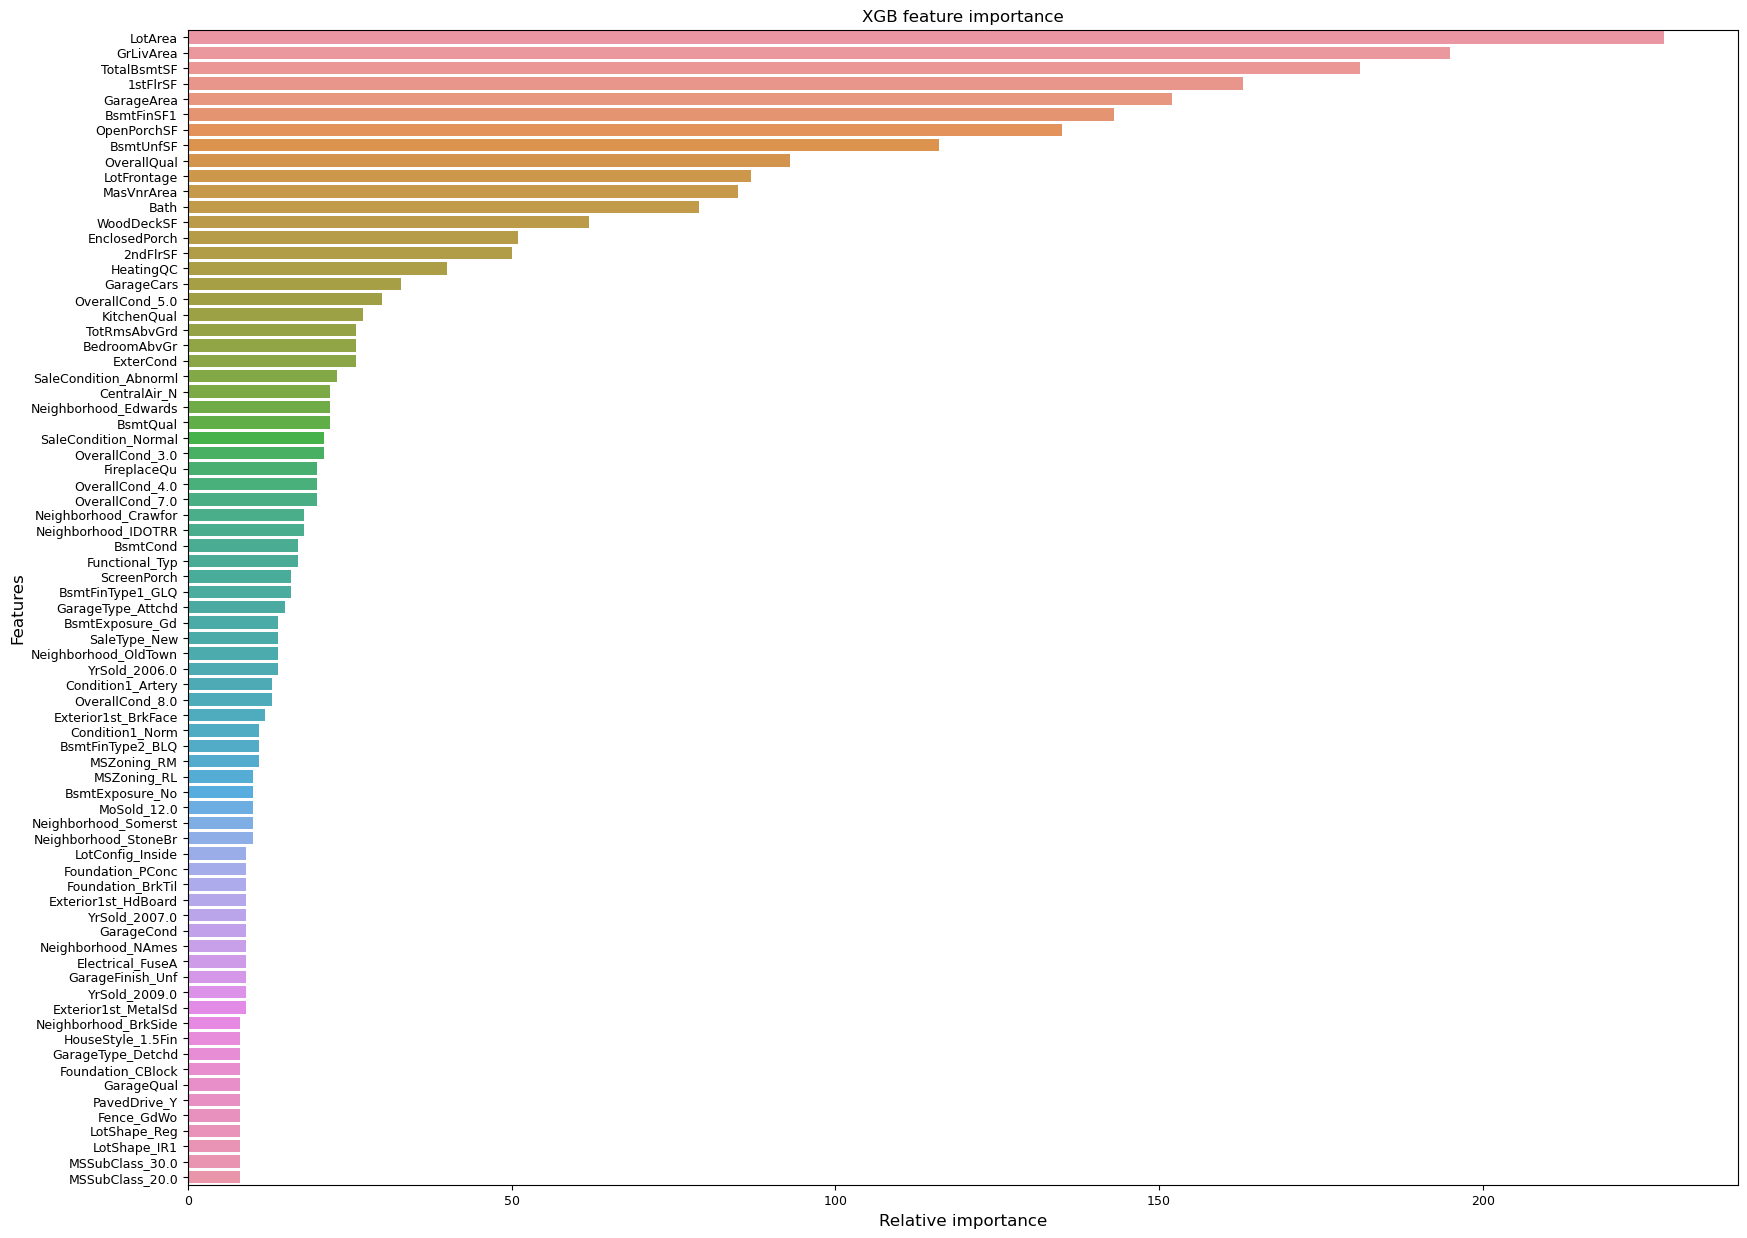

In [44]:
# Visualise these with a barplot
plt.subplots(figsize=(20, 15))
g = sns.barplot(y=tdf.columns[ifeatures_ind[:75]], x = model_lgb.feature_importances_[ifeatures_ind[:75]], orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("XGB feature importance");

#### Models

In [74]:
# prepare train / validation
tdf = df.copy()
tdf = fill_miss(tdf)
# normalizing
power = PowerTransformer(method='yeo-johnson', standardize=True)
power.fit(tdf[num_cols_norm])
tdf[num_cols_norm] = power.transform(tdf[num_cols_norm])
tdf = feat_eng(tdf, num_cols_tdrop, num_cols_norm, num_cols_flag)
tdf = transf_cat(tdf, cat_cols_oh, cat_cols_oe, cat_cols_tdrop)
label = np.log1p(tdf['SalePrice'])
tdf.drop(['Id', 'SalePrice'], axis=1, inplace=True)

tdf = tdf[ifeatures]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(tdf, label, test_size=0.25, random_state=rst)

In [76]:

#Machine Learning Algorithm (MLA) Selection and Initialization
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), SVR(), RandomForestRegressor(), cb.CatBoostRegressor(verbose=False), LGBMRegressor(verbose=-1)]

for model in models:
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    rmse = (np.sqrt(mean_squared_error(y_test, pred)))
    r2 = r2_score(y_test, pred)
    print('Testing performance', model.__class__.__name__)
    print('RMSE: {:.2f}'.format(rmse))
    print('R2: {:.2f}'.format(r2), '\n')


Testing performance KernelRidge
RMSE: 0.49
R2: -0.49 

Testing performance ElasticNet
RMSE: 0.40
R2: 0.02 

Testing performance Lasso
RMSE: 0.40
R2: 0.02 

Testing performance GradientBoostingRegressor
RMSE: 0.13
R2: 0.89 

Testing performance BayesianRidge
RMSE: 0.12
R2: 0.91 

Testing performance SVR
RMSE: 0.20
R2: 0.76 

Testing performance RandomForestRegressor
RMSE: 0.15
R2: 0.87 

Testing performance CatBoostRegressor
RMSE: 0.13
R2: 0.90 

Testing performance LGBMRegressor
RMSE: 0.14
R2: 0.87 



In [78]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), SVR(), RandomForestRegressor(), cb.CatBoostRegressor(verbose=False), LGBMRegressor(verbose=-1)]

KR_param_grid = {'alpha': [0.1], 'coef0': [1], 'degree': [1], 'gamma': [None], 'kernel': ['polynomial']}
EN_param_grid = {'alpha': [0.001], 'copy_X': [True], 'l1_ratio': [0.6], 'fit_intercept': [True], #'normalize': [False], 
                         'precompute': [False], 'max_iter': [300], 'tol': [0.001], 'selection': ['random'], 'random_state': [None]}
LASS_param_grid = {'alpha': [0.0005], 'copy_X': [True], 'fit_intercept': [True], 'precompute': [False], #'normalize': [False], 
                    'max_iter': [300], 'tol': [0.01], 'selection': ['random'], 'random_state': [None]}
GB_param_grid = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [300], 'max_depth': [3], 
                                        'min_samples_split': [0.0025], 'min_samples_leaf': [5]}
BR_param_grid = {'max_iter': [200], 'tol': [0.00001], 'alpha_1': [0.00000001], 'alpha_2': [0.000005], 'lambda_1': [0.000005], 
                 'lambda_2': [0.00000001], 'copy_X': [True]}
SVR_param_grid = {'C': [20], 'epsilon': [0.05], 'gamma': [0.0003]}
RFR_param_grid = {'n_estimators': [50], 'max_depth': [None], 'min_samples_split': [5], 'min_samples_leaf': [2]} #'max_features': ['auto'], 
CB_param_grid = {'iterations': [200],
        'learning_rate': [0.1],
        'depth': [4],
        'l2_leaf_reg': [0.5]}
LGB_param_grid = {
    'learning_rate': [0.05],
    "max_depth": [8 ],
    "num_leaves": [180], 
    "max_bin": [200],
    'n_estimators': [250]
}

params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, SVR_param_grid, RFR_param_grid, CB_param_grid, LGB_param_grid]
shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(X_train, y_train)
    gs_best = gs_alg.best_estimator_
   

    pred = gs_alg.predict(X_test)

    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    after_training_results = np.sqrt(-gs_alg.best_score_)
    after_test_results = np.sqrt(((y_test-gs_alg.predict(X_test))**2).mean())
    
    rmse = (np.sqrt(mean_squared_error(y_test, pred)))
    r2 = r2_score(y_test, pred)
    print('Testing performance', alg.__class__.__name__)
    print(str(gs_alg.best_params_))
    print('RMSE: {:.2f}'.format(rmse))
    print('R2: {:.2f}'.format(r2), '\n')

# decimals = 3
# after_model_compare['Train Accuracy Mean'] = after_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
# after_model_compare['Test Accuracy'] = after_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
# after_model_compare

Testing performance KernelRidge
{'alpha': 0.1, 'coef0': 1, 'degree': 1, 'gamma': None, 'kernel': 'polynomial'}
RMSE: 0.13
R2: 0.90 

Testing performance ElasticNet
{'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.6, 'max_iter': 300, 'precompute': False, 'random_state': None, 'selection': 'random', 'tol': 0.001}
RMSE: 0.12
R2: 0.91 

Testing performance Lasso
{'alpha': 0.0005, 'copy_X': True, 'fit_intercept': True, 'max_iter': 300, 'precompute': False, 'random_state': None, 'selection': 'random', 'tol': 0.01}
RMSE: 0.12
R2: 0.91 

Testing performance GradientBoostingRegressor
{'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 0.0025, 'n_estimators': 300}
RMSE: 0.13
R2: 0.90 

Testing performance BayesianRidge
{'alpha_1': 1e-08, 'alpha_2': 5e-06, 'copy_X': True, 'lambda_1': 5e-06, 'lambda_2': 1e-08, 'max_iter': 200, 'tol': 1e-05}
RMSE: 0.12
R2: 0.91 

Testing performance SVR
{'C': 20, 'epsilon': 0.05, 'gamma': 0.0003}


In [80]:
# outliers
rem_id = [30, 88, 462, 631, 1322]

# prepare train / validation
tdf = df.copy()
tdf = tdf[~tdf['Id'].isin(rem_id)]
tdf = fill_miss(tdf)
# normalizing
power = PowerTransformer(method='yeo-johnson', standardize=True)
power.fit(tdf[num_cols_norm])
tdf[num_cols_norm] = power.transform(tdf[num_cols_norm])
tdf = feat_eng(tdf, num_cols_tdrop, num_cols_norm, num_cols_flag)
tdf = transf_cat(tdf, cat_cols_oh, cat_cols_oe, cat_cols_tdrop)
label = np.log1p(tdf['SalePrice'])
tdf.drop(['Id', 'SalePrice'], axis=1, inplace=True)

tdf = tdf[ifeatures]

In [81]:
X_train, X_test, y_train, y_test = train_test_split(tdf, label, test_size=0.25, random_state=rst)

In [82]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), SVR(), RandomForestRegressor(), cb.CatBoostRegressor(verbose=False), LGBMRegressor(verbose=-1)]

KR_param_grid = {'alpha': [0.1], 'coef0': [1], 'degree': [1], 'gamma': [None], 'kernel': ['polynomial']}
EN_param_grid = {'alpha': [0.001], 'copy_X': [True], 'l1_ratio': [0.6], 'fit_intercept': [True], #'normalize': [False], 
                         'precompute': [False], 'max_iter': [300], 'tol': [0.001], 'selection': ['random'], 'random_state': [None]}
LASS_param_grid = {'alpha': [0.0005], 'copy_X': [True], 'fit_intercept': [True], 'precompute': [False], #'normalize': [False], 
                    'max_iter': [300], 'tol': [0.01], 'selection': ['random'], 'random_state': [None]}
GB_param_grid = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [300], 'max_depth': [3], 
                                        'min_samples_split': [0.0025], 'min_samples_leaf': [5]}
BR_param_grid = {'max_iter': [200], 'tol': [0.00001], 'alpha_1': [0.00000001], 'alpha_2': [0.000005], 'lambda_1': [0.000005], 
                 'lambda_2': [0.00000001], 'copy_X': [True]}
SVR_param_grid = {'C': [20], 'epsilon': [0.05], 'gamma': [0.0003]}
RFR_param_grid = {'n_estimators': [50], 'max_depth': [None], 'min_samples_split': [5], 'min_samples_leaf': [2]} #'max_features': ['auto'], 
CB_param_grid = {'iterations': [200],
        'learning_rate': [0.1],
        'depth': [4],
        'l2_leaf_reg': [0.5]}
LGB_param_grid = {
    'learning_rate': [0.05],
    "max_depth": [8 ],
    "num_leaves": [180], 
    "max_bin": [200],
    'n_estimators': [250]
}

params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, SVR_param_grid, RFR_param_grid, CB_param_grid, LGB_param_grid]
shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(X_train, y_train)
    gs_best = gs_alg.best_estimator_
   

    pred = gs_alg.predict(X_test)

    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    after_training_results = np.sqrt(-gs_alg.best_score_)
    after_test_results = np.sqrt(((y_test-gs_alg.predict(X_test))**2).mean())
    
    rmse = (np.sqrt(mean_squared_error(y_test, pred)))
    r2 = r2_score(y_test, pred)
    print('Testing performance', alg.__class__.__name__)
    print(str(gs_alg.best_params_))
    print('RMSE: {:.2f}'.format(rmse))
    print('R2: {:.2f}'.format(r2), '\n')

# decimals = 3
# after_model_compare['Train Accuracy Mean'] = after_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
# after_model_compare['Test Accuracy'] = after_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
# after_model_compare

Testing performance KernelRidge
{'alpha': 0.1, 'coef0': 1, 'degree': 1, 'gamma': None, 'kernel': 'polynomial'}
RMSE: 0.13
R2: 0.87 

Testing performance ElasticNet
{'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.6, 'max_iter': 300, 'precompute': False, 'random_state': None, 'selection': 'random', 'tol': 0.001}
RMSE: 0.13
R2: 0.88 

Testing performance Lasso
{'alpha': 0.0005, 'copy_X': True, 'fit_intercept': True, 'max_iter': 300, 'precompute': False, 'random_state': None, 'selection': 'random', 'tol': 0.01}
RMSE: 0.13
R2: 0.88 

Testing performance GradientBoostingRegressor
{'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 0.0025, 'n_estimators': 300}
RMSE: 0.14
R2: 0.87 

Testing performance BayesianRidge
{'alpha_1': 1e-08, 'alpha_2': 5e-06, 'copy_X': True, 'lambda_1': 5e-06, 'lambda_2': 1e-08, 'max_iter': 200, 'tol': 1e-05}
RMSE: 0.13
R2: 0.88 

Testing performance SVR
{'C': 20, 'epsilon': 0.05, 'gamma': 0.0003}


#### Test data

In [ ]:
test_data = pd.read_csv('test.csv')

test_data = fill_miss(test_data)
# normalizing
test_data[num_cols_norm] = power.transform(test_data[num_cols_norm])
test_data = feat_eng(test_data, num_cols_tdrop, num_cols_norm, num_cols_flag)
test_data = transf_cat(test_data, cat_cols_oh, cat_cols_oe, cat_cols_tdrop)
t_id = test_data['Id']
test_data.drop('Id', axis=1, inplace=True)

test_data = test_data[ifeatures]

In [ ]:
y_tpred_CBR = model.predict(test_data)

# create submission file
subm = pd.DataFrame()
subm['Id'] = t_id
subm['SalePrice'] = y_tpred_CBR
subm.set_index('Id').to_csv('submission_cbr2.csv')